## Replication of electricity price forecasting

### Days of the week/ Holidays

In [1]:
from electricity_price_predictor.data import get_shifted_load, get_shifted_price, get_weather, get_holidays, get_days_dummies, get_coal_price
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
last_date = '2020-11-23 16:00:00'
first_date = '2015-11-25 00:00:00'

In [3]:
dayofweek = get_days_dummies().loc[first_date:last_date]
holidays = get_holidays().loc[first_date:last_date]
weather = get_weather().loc[first_date:last_date]
price = get_shifted_price().loc[first_date:last_date]
load = get_shifted_load().loc[first_date:last_date]
coal = get_coal_price().loc[first_date:last_date]

In [4]:
# merge price and load into one df
df = price.merge(load, on='time')

## Downsample

In [ ]:
weather_D = weather[weather.index.hour==11]
weather 

In [5]:
weather = weather.resample('D').mean()
weather = weather.reset_index().drop('dt', axis=1)

In [ ]:
weather

In [6]:
df = df.resample('D').mean()
df = df.reset_index().drop('time', axis=1)

In [7]:
dayofweek = dayofweek.reset_index().drop('index', axis=1)
holidays = holidays.reset_index().drop('index', axis=1)

In [8]:
coal = coal.resample('D').mean()
coal = coal.reset_index().drop('time', axis=1)

In [9]:
print(f"'holidays:' {holidays.shape}")
print(f"'day of week:' {dayofweek.shape}")
print(f"'weather:' {weather.shape}")
print(f"'price, load:' {df.shape}")
print(f"'coal:' {coal.shape}")

'holidays:' (1826, 2)
'day of week:' (1826, 7)
'weather:' (1826, 5)
'price, load:' (1826, 2)
'coal:' (1826, 1)


## Merging dataframes

In [10]:
df = df.join(coal).join(
    holidays).join(
    dayofweek).join(
    weather).drop('holiday_name', axis=1)

df['holiday_bool'] = df['holiday_bool'].astype('int64')

In [ ]:
# df = df.merge(
#     holidays, right_index= True, left_index=True).merge(
#     dayofweek, right_index= True, left_index=True).merge(
#     weather, right_index= True, left_index= True).merge(
#     coal, right_index=True, left_index=True).drop('holiday_name', axis=1)

# df['holiday_bool'] = df['holiday_bool'].astype('int64')

In [11]:
df

,price,load,coal_price,holiday_bool,mon,tue,wed,thur,fri,sat,sun,temp,feels_like,humidity,clouds_all,wind_speed
0,32.537083,2588.416667,46.05,0,0,0,1,0,0,0,0,4.781124,1.426813,94.787551,60.941129,2.915235
1,33.248333,2601.625000,46.35,0,0,0,0,1,0,0,0,3.307241,-0.246577,88.873078,23.614085,2.606222
2,22.573333,2513.583333,46.45,0,0,0,0,0,1,0,0,6.981943,1.428417,93.255776,85.358695,6.620643
3,20.322083,2085.666667,46.45,0,0,0,0,0,0,1,0,5.368526,-0.016180,88.564411,67.243748,5.721742
4,12.707917,2050.125000,46.45,0,0,0,0,0,0,0,1,6.278432,-0.801260,86.465926,75.811254,8.294217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,1.047083,2705.500000,52.75,0,0,0,0,1,0,0,0,7.011803,0.472592,75.156521,28.890113,7.285472
1822,33.003750,2715.333333,53.00,0,0,0,0,0,1,0,0,4.028544,-0.088680,78.171198,21.466404,3.165625
1823,1.046250,2429.583333,53.00,0,0,0,0,0,0,1,0,8.117413,3.327187,93.313982,50.146651,5.922855
1824,1.158333,2330.458333,53.00,0,0,0,0,0,0,0,1,7.777668,2.726794,82.615943,28.811757,5.605095


In [12]:
def shift_by_days(data, num_days):
    """
    Input a timeseries of the form 24 hourly measurements per day
    
    Output returns 
    
    """
    data_shifted = data.shift(num_days)
    
    return data_shifted

In [13]:
df['price_t_1'] = shift_by_days(df['price'], 1)

In [14]:
df['price_t_7'] = shift_by_days(df['price'], 7)

In [15]:
df = df.dropna()

In [31]:
df

,price,load,coal_price,holiday_bool,mon,tue,wed,thur,fri,sat,sun,temp,feels_like,humidity,clouds_all,wind_speed,price_t_1,price_t_7
7,23.992500,2545.416667,45.55,0,0,0,1,0,0,0,0,8.224211,4.011582,90.504803,81.208875,4.961631,23.686250,32.537083
8,25.597500,2598.250000,45.85,0,0,0,0,1,0,0,0,8.811838,5.446127,96.349046,91.698916,4.242559,23.992500,33.248333
9,20.534167,2383.041667,45.90,0,0,0,0,0,1,0,0,8.082088,1.172631,83.590467,70.398758,8.400877,25.597500,22.573333
10,15.230417,2102.416667,45.90,0,0,0,0,0,0,1,0,9.696045,0.805741,86.093783,92.803450,11.859096,20.534167,20.322083
11,11.293333,1997.833333,45.90,0,0,0,0,0,0,0,1,9.734235,1.591350,85.900014,83.595588,10.818547,15.230417,12.707917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,1.047083,2705.500000,52.75,0,0,0,0,1,0,0,0,7.011803,0.472592,75.156521,28.890113,7.285472,0.991667,35.625417
1822,33.003750,2715.333333,53.00,0,0,0,0,0,1,0,0,4.028544,-0.088680,78.171198,21.466404,3.165625,1.047083,38.207917
1823,1.046250,2429.583333,53.00,0,0,0,0,0,0,1,0,8.117413,3.327187,93.313982,50.146651,5.922855,33.003750,31.870000
1824,1.158333,2330.458333,53.00,0,0,0,0,0,0,0,1,7.777668,2.726794,82.615943,28.811757,5.605095,1.046250,3.430000


In [78]:
df_new = df[[ 'coal_price', 'holiday_bool', 'feels_like',
       'clouds_all', 'wind_speed' ]]

In [80]:
df.corr().style.background_gradient(cmap='coolwarm')

,price,load,coal_price,holiday_bool,mon,tue,wed,thur,fri,sat,sun,temp,feels_like,humidity,clouds_all,wind_speed,price_t_1,price_t_7,pred_price
price,1.000000,0.218302,0.607520,-0.147637,0.048783,0.071923,0.072566,0.067684,0.061930,-0.122812,-0.199957,0.076624,0.152971,0.049673,0.123872,-0.470013,0.773211,0.613691,0.825428
load,0.218302,1.000000,0.035383,-0.233062,0.139348,0.212039,0.222700,0.206638,0.048598,-0.393445,-0.435537,-0.432190,-0.419994,0.241147,0.123846,0.062013,0.094290,0.190856,0.316128
coal_price,0.607520,0.035383,1.000000,-0.040381,0.001564,0.002648,-0.001147,-0.000522,-0.000846,-0.000846,-0.000846,0.058212,0.062689,0.014061,0.200672,-0.034388,0.606757,0.604548,0.322780
holiday_bool,-0.147637,-0.233062,-0.040381,1.000000,0.038906,-0.048828,-0.049040,0.021317,0.030111,-0.066629,0.074084,-0.044039,-0.058359,-0.098003,-0.048117,0.046600,-0.107392,-0.074727,-0.136980
mon,0.048783,0.139348,0.001564,0.038906,1.000000,-0.166399,-0.166774,-0.166774,-0.166774,-0.166774,-0.166774,-0.011524,-0.012589,-0.022037,-0.033242,-0.000251,-0.200435,0.048499,-0.019098
tue,0.071923,0.212039,0.002648,-0.048828,-0.166399,1.000000,-0.166399,-0.166399,-0.166399,-0.166399,-0.166399,-0.000908,-0.006004,-0.029273,0.005296,0.022565,0.051735,0.073061,0.183836
wed,0.072566,0.222700,-0.001147,-0.049040,-0.166774,-0.166399,1.000000,-0.166774,-0.166774,-0.166774,-0.166774,0.010363,0.007235,-0.000873,0.009964,0.022657,0.070497,0.074968,0.142479
thur,0.067684,0.206638,-0.000522,0.021317,-0.166774,-0.166399,-0.166774,1.000000,-0.166774,-0.166774,-0.166774,0.008622,0.007363,0.016364,0.016873,0.009668,0.072345,0.070129,0.073203
fri,0.061930,0.048598,-0.000846,0.030111,-0.166774,-0.166399,-0.166774,-0.166774,1.000000,-0.166774,-0.166774,0.000981,0.005334,-0.001431,-0.012685,-0.028730,0.067459,0.059064,0.090375
sat,-0.122812,-0.393445,-0.000846,-0.066629,-0.166774,-0.166399,-0.166774,-0.166774,-0.166774,1.000000,-0.166774,-0.004566,-0.000024,0.025873,0.030191,-0.020993,0.061700,-0.123451,-0.133994


In [ ]:
df1 = pd.DataFrame()
df1["vif_index"] = [vif(df.values, i) for i in range(df.shape[1])]
df1["features"] = df.columns
df1[['features', 'vif_index']].sort_values(by='vif_index', ascending=False)

In [79]:
df1 = pd.DataFrame()
df1["vif_index"] = [vif(df_new.values, i) for i in range(df_new.shape[1])]
df1["features"] = df_new.columns
df1[['features', 'vif_index']].sort_values(by='vif_index', ascending=False)

,features,vif_index
0,coal_price,11.553314
3,clouds_all,7.329885
4,wind_speed,6.325441
2,feels_like,1.785227
1,holiday_bool,1.039336


## Define features and scale

In [16]:
X = df.drop(['price', 'feels_like'], axis=1)
y = df.price

In [17]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Data visualization

In [ ]:
df.describe().applymap(lambda x: round(x))

In [ ]:
df[['price']].boxplot()

<AxesSubplot:title={'center':'Seaborn'}, xlabel='price', ylabel='Count'>

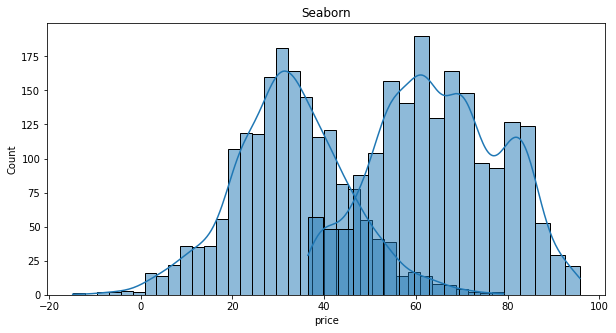

In [69]:
plt.figure(figsize=(10, 5))


plt.title('Seaborn')
sns.histplot(df['price'], kde=True);
sns.histplot(df['coal_price'], kde=True)

c:\users\gesi\.venvs\energy_price\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\gesi\.venvs\energy_price\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='coal_price', ylabel='price'>

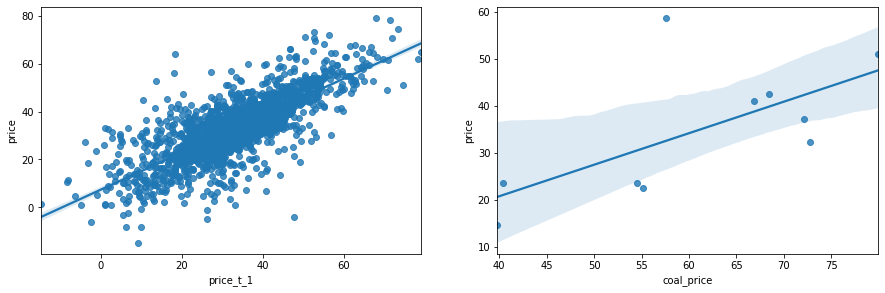

In [70]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot('price_t_1', 'price', data=df, ci=95)
plt.subplot(2,2,2)
sns.regplot('coal_price', 'price', data=df.sample(10), ci=95)

<AxesSubplot:xlabel='coal_price', ylabel='price'>

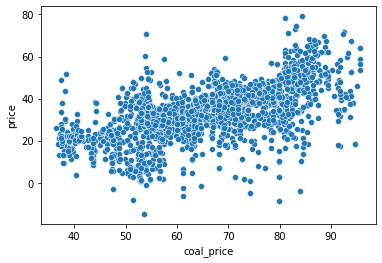

In [68]:
sns.scatterplot(x='coal_price', y='price', data=df)

c:\users\gesi\.venvs\energy_price\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='coal_price', ylabel='price'>

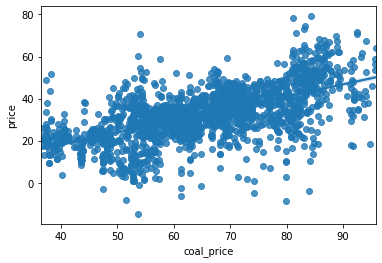

In [71]:
sns.regplot('coal_price', 'price', data=df)

## Model


### LinearReg Sklearn

In [18]:
model_2 = LinearRegression()
model_2.fit(X_scaled, y)
model_2.score(X_scaled, y)  # R2

0.801362902727311

In [19]:
model_2.coef_

array([ 2.22744776e-01,  1.14970535e+01, -5.02527546e+00, -3.60726627e+14,
       -3.60726627e+14, -3.60726627e+14, -3.60726627e+14, -3.60726627e+14,
       -3.60726627e+14, -3.60726627e+14, -4.23865699e+00, -4.20988281e+00,
        2.88772666e+00, -2.86792688e+01,  4.31571785e+01,  1.58170472e+01])

### smf statsmodels

In [20]:
col = df.columns[1:]

In [21]:
formula = ' + '.join(col)
formula = f"price ~ {formula}"
formula

'price ~ load + coal_price + holiday_bool + mon + tue + wed + thur + fri + sat + sun + temp + feels_like + humidity + clouds_all + wind_speed + price_t_1 + price_t_7'

In [99]:
model_3 = smf.ols('price ~ load + mon + tue + wed + thur + fri + sat + sun + holiday_bool + coal_price + humidity  + temp + wind_speed + feels_like + price_t_1 + price_t_7', data=df).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     483.6
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:38:19   Log-Likelihood:                -5752.3
No. Observations:                1819   AIC:                         1.154e+04
Df Residuals:                    1803   BIC:                         1.162e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.3845      3.755      5.162      0.000      12.020      26.749
load            -0.0008      0.001     -0.857      0.392      -0.003       0.001
mon              7.0704      0.675     10.474      0.000       5.747       8.394
tue              4.0812      0.690      5.918      0.000       2.729       5.434
wed              3.8793      0.692      5.606      0.000       2.522       5.236
thur             3.7656      0.699      5.389      0.000       2.395       5.136
fri              3.2109      0.645      4.980      0.000       1.946       4.475
sat             -1.8838      0.583     -3.232      0.001      -3.027      -0.741
sun             -0.7391      0.575     -1.287      0.198      -1.866       0.388
holiday_bool    -5.1646      0.830     -6.223      0.000      -6.792      -3.537
coal_price       0.2022      0.014     14.176      0.000       0.174       0.230
humidity        -0.0773      0.028     -2.807      0.005      -0.131      -0.023
temp            -1.5104      0.706     -2.141      0.032      -2.894      -0.127
wind_speed      -1.8333      0.416     -4.405      0.000      -2.650      -1.017
feels_like       1.1190      0.581      1.925      0.054      -0.021       2.259
price_t_1        0.4652      0.016     28.795      0.000       0.434       0.497
price_t_7        0.1704      0.015     11.327      0.000       0.141       0.200
==============================================================================
Omnibus:                      111.783   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.686
Skew:                          -0.178   Prob(JB):                     2.43e-90
Kurtosis:                       5.306   Cond. No.                     2.88e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [97]:
model_3_1 = smf.ols('price ~  holiday_bool + feels_like + coal_price  + clouds_all + wind_speed', data=df).fit()
model_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     519.3
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:37:05   Log-Likelihood:                -6411.9
No. Observations:                1819   AIC:                         1.284e+04
Df Residuals:                    1813   BIC:                         1.287e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.8719      1.142      8.643      0.000       7.632      12.112
holiday_bool    -7.1088      1.086     -6.548      0.000      -9.238      -4.980
feels_like      -0.0076      0.028     -0.270      0.787      -0.063       0.047
coal_price       0.5391      0.015     36.772      0.000       0.510       0.568
clouds_all       0.0455      0.008      5.381      0.000       0.029       0.062
wind_speed      -3.6094      0.124    -29.091      0.000      -3.853      -3.366
==============================================================================
Omnibus:                       35.646   Durbin-Watson:                   0.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.286
Skew:                          -0.059   Prob(JB):                     5.46e-16
Kurtosis:                       3.956   Cond. No.                         544.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
train = df.iloc[: 1796,:]
test = df.iloc[1796:, :]

In [87]:
model_4 = smf.ols('price ~ load + mon + tue + wed + thur + fri + sat + sun + holiday_bool + coal_price + humidity  + temp + wind_speed + price_t_1 + price_t_7', data=train).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     519.1
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:16:57   Log-Likelihood:                -5647.0
No. Observations:                1796   AIC:                         1.132e+04
Df Residuals:                    1781   BIC:                         1.141e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.8813      2.223      5.345      0.000       7.521      16.241
load         -4.807e-05      0.001     -0.053      0.958      -0.002       0.002
mon              5.8641      0.523     11.215      0.000       4.839       6.890
tue              2.8957      0.527      5.499      0.000       1.863       3.929
wed              2.7120      0.535      5.069      0.000       1.663       3.761
thur             2.5901      0.537      4.822      0.000       1.537       3.644
fri              1.9468      0.472      4.128      0.000       1.022       2.872
sat             -2.6662      0.389     -6.851      0.000      -3.430      -1.903
sun             -1.4611      0.398     -3.670      0.000      -2.242      -0.680
holiday_bool    -5.0659      0.815     -6.218      0.000      -6.664      -3.468
coal_price       0.1955      0.014     13.992      0.000       0.168       0.223
humidity        -0.0299      0.015     -1.992      0.047      -0.059      -0.000
temp            -0.1341      0.030     -4.519      0.000      -0.192      -0.076
wind_speed      -2.5844      0.088    -29.332      0.000      -2.757      -2.412
price_t_1        0.4563      0.016     28.111      0.000       0.424       0.488
price_t_7        0.1856      0.015     12.298      0.000       0.156       0.215
==============================================================================
Omnibus:                      111.791   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.313
Skew:                          -0.167   Prob(JB):                     4.41e-93
Kurtosis:                       5.360   Cond. No.                     1.77e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [88]:
test['pred_price'] =  model_4.predict(test)

c:\users\gesi\.venvs\energy_price\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
MAPE = ((abs(test['price'] - test['pred_price']))/(test['price'])).mean()*100

In [90]:
MAPE

310.52391884464276

In [30]:
df.columns

Index(['price', 'load', 'coal_price', 'holiday_bool', 'mon', 'tue', 'wed',
       'thur', 'fri', 'sat', 'sun', 'temp', 'feels_like', 'humidity',
       'clouds_all', 'wind_speed', 'price_t_1', 'price_t_7'],
      dtype='object')

In [28]:
model_3.predict()

array([23.32500443, 25.11682251, 13.2450796 , ..., 21.00238685,
        3.61053035, 14.3492496 ])

In [ ]:
residuals = model_3.resid
sns.distplot(model_3.resid)

In [ ]:
predictions = model_3.predict()

In [ ]:
# Check with Residuals vs. Fitted scatterplot
sns.scatterplot(predictions, residuals)
plt.xlabel('Predicted weight')
plt.ylabel('Residual weight')

In [ ]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot


In [ ]:
lag_plot(df['price'], lag=1)

<AxesSubplot:>

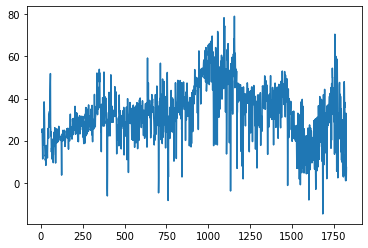

In [72]:
df['price'].plot()

<AxesSubplot:>

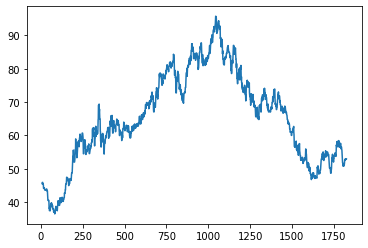

In [73]:
df['coal_price'].plot()

In [ ]:
autocorrelation_plot(df['temp'])

In [ ]:
fig = plt.figure(figsize=(10,36))
fig = sm.graphics.plot_partregress_grid(model_3, fig=fig)

In [ ]:
model = smf.ols(formula=formula, data=df).fit()

In [ ]:
model.summary()

In [ ]:
data_train, data_test = train_test_split

In [ ]:
# from sklearn.model_selection import train_test_split

# # Ready X and y
# X = df.drop(['price', 'feels_like'], axis=1)
# y = df['price']

# # Split into Train/Test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 4)

In [ ]:
lin_model = LinearRegression()

# Train the model on the Training data
lin_model.fit(X_train, y_train)

# Score the model on the Training data
lin_model.score(X_train,y_train)

In [ ]:
# Score the model on the Testing data
lin_model.score(X_test,y_test)

In [91]:
from sklearn.metrics import mean_squared_error

In [119]:
y_pred = model_3.predict()

In [120]:
import math

mse = mean_squared_error(y, y_pred)

rmse = math.sqrt(mse)

In [121]:
rmse

5.716790555726477